In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, lil_matrix, coo_matrix
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh

In [5]:
import math

In [6]:
def Vmax(X):
  X=np.array(X)
  t=np.var(X,axis=0)
  mv=np.argmax(t)
  fp=np.argmax(np.abs(X[:,mv] - np.mean(X, axis=0)[mv]))
  vmax = X[:,mv][fp] - np.mean(X, axis=0)[mv]

  return vmax, mv


def P(X,indces):
  p = X[indces] - np.mean(X[indces], axis=0)
  d={}
  for i in range(len(indces)):d[indces[i]] = p[i]
  return d


def partitionDis2(X,C,tem,length,K_):
  k=len(C)
  if k <= math.ceil(length**(K_)):
    cmax= np.argmax(tem)
    vmax,mv = Vmax(X[C[cmax]])
    p = P(X,C[cmax])
    c1,c2,i1,i2=[],[],[],[]
    for i in C[cmax]:
      if (p[i][mv]*(vmax)) >= 0:c1.append(i)
      else:c2.append(i)
    C.pop(cmax),C.append(c1),C.append(c2)
    tem.pop(cmax),tem.append(sum(np.var(X[c1],axis=0))),tem.append(sum(np.var(X[c2],axis=0)))
    k= len(C)
    partitionDis2(X,C,tem,length,K_)

In [86]:
df = pd.read_csv('/content/drive/MyDrive/Dataset_for_me/breast-cancer.txt', sep='\t', header=None)
X=np.array(df.iloc[:,:-1])

In [87]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [88]:
df.shape

(699, 10)

In [89]:
gt_lab = np.array(df.iloc[:, -1])

k = len(set(gt_lab))

In [90]:
C = [np.arange(len(X))]
tem = [sum(np.var(X[i],axis=0)) for i in C]
partitionDis2(X,C,tem,len(X),1/2)

In [10]:
# for i in C:
#   plt.scatter(X[i][:,0], X[i][:,1])

In [91]:
centroids = np.array([X[cluster].mean(axis=0) for cluster in C])

In [12]:
centroids

array([[  42.        , -381.        ,  116.        , ...,  -31.        ,
         105.        , -179.        ],
       [  -9.5       ,  -19.        ,   85.        , ...,  -42.5       ,
         338.        , -103.        ],
       [-166.        ,  -16.        ,   77.5       , ..., -362.5       ,
          61.5       ,  111.        ],
       ...,
       [ -87.125     , -157.5       ,   59.375     , ...,   25.25      ,
         242.125     ,  -27.875     ],
       [ -80.83333333,  -76.08333333,  -30.33333333, ...,  -15.5       ,
         120.91666667,  -86.25      ],
       [ -91.88461538,  -80.53846154,  -13.57692308, ...,  -74.26923077,
          57.30769231,  -99.96153846]])

In [92]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial import distance

def k_round_MST_sgmst(X, K, adjMat_precomputed=False, SG=None):
    edges = []

    if not adjMat_precomputed:
        adjMat = np.tril(distance.cdist(X, X, 'euclidean'), -1)
    else:
        adjMat = csr_matrix((len(X), len(X)))
        adjMat[np.array(SG)[:, 0], np.array(SG)[:, 1]] = np.sqrt(np.sum((X[np.array(SG)[:, 0]] - X[np.array(SG)[:, 1]])**2, axis=1))

    for i in range(K):
        Tcsr = minimum_spanning_tree(csr_matrix(adjMat))
        a, b = np.where((Tcsr != 0).toarray())
        edges.append(np.column_stack((a, b)))

        if adjMat_precomputed:
            adjMat -= Tcsr
        else:
            adjMat -= Tcsr.toarray()

    return np.vstack(edges)

In [93]:
NG = k_round_MST_sgmst(centroids,2)

In [94]:
import matplotlib.pyplot as plt

def draw_k_round_mst(X, edges, title='K-Round MST'):
    """
    X: data points (n_samples, n_features)
    edges: array of edge pairs (from k_round_MST_sgmst)
    title: plot title
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c='red', s=80, zorder=2, label='Points')

    # Draw MST edges
    for i, j in edges:
        x_vals = [X[i][0], X[j][0]]
        y_vals = [X[i][1], X[j][1]]
        plt.plot(x_vals, y_vals, 'k-', alpha=0.6, linewidth=2, zorder=1)

    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()



In [16]:
# draw_k_round_mst(centroids,k_round_MST_sgmst(centroids,2))

In [95]:
def bipartite(p1,p2):
  return [[i,j] for i in p1 for j in p2]

In [96]:
G = []

for i,j in NG:
  G+= bipartite(C[i],C[j])


In [19]:
# draw_k_round_mst(X, G, title='New Bipartiate')


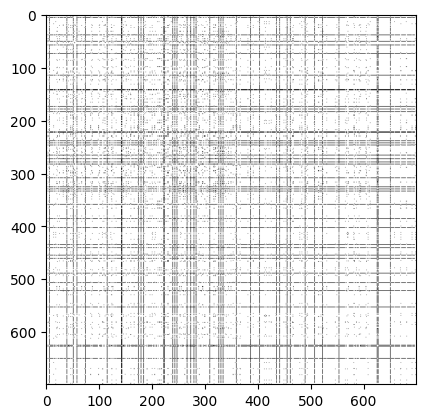

In [97]:
N, f = X.shape
G = np.array(G)
A = lil_matrix((N, N))
A[G[:, 0], G[:, 1]] = 1
A[G[:, 1], G[:, 0]] = 1
plt.imshow(A.toarray(), cmap='gray_r')

In [98]:
L, D = laplacian(A, return_diag=True)

In [175]:
val, vec = eigsh(L, k = 9 )  # here k = 6 need to tune

In [176]:
vec

array([[ 1.73472348e-18, -7.80625564e-18, -1.64798730e-17, ...,
         2.87118957e-15, -8.71047418e-03,  8.13911573e-03],
       [ 5.42101086e-19, -1.70761842e-17, -8.94466792e-19, ...,
        -5.59409498e-17,  2.66752326e-04, -5.41791787e-04],
       [ 3.46944695e-18, -6.93889390e-18, -1.69135539e-17, ...,
         2.87083460e-15, -8.71047418e-03,  8.13911573e-03],
       ...,
       [ 1.73472348e-18, -8.23993651e-18, -1.73472348e-17, ...,
         2.86976258e-15, -8.71047418e-03,  8.13911573e-03],
       [ 5.50190251e-18,  1.07124522e-18,  1.97467865e-18, ...,
         1.79959279e-17,  1.65077274e-07, -1.76068404e-07],
       [ 7.97367700e-18,  5.77540151e-18,  6.92613878e-18, ...,
         1.04107165e-17,  1.10593170e-07, -9.43437923e-08]])

In [177]:
vec.shape

(699, 9)

In [23]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [24]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score
from tensorflow.keras.utils import to_categorical

In [27]:
#X=np.array(df.iloc[:, :-1])

In [25]:
X.shape

(60, 7129)

In [29]:
X

array([[ -60, -109,   45, ...,  -25,   56,  -63],
       [-159, -113,  -62, ..., -750,  -45, -293],
       [-119,  -31,    4, ...,   11,    2,    2],
       ...,
       [-101,  -80,   22, ...,   -8,  -57,  -76],
       [  12,  -91,  218, ...,  149,  157,  -19],
       [ -59,  -85,   49, ...,   26,  491,   13]])

In [30]:
#y= np.array(df.iloc[:,-1])

In [31]:
#np.unique(y)

In [178]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(gt_lab)

In [179]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vec, y_encoded, test_size=0.2, random_state=42)

In [180]:
from tensorflow.keras.layers import Dropout

In [186]:
# model = Sequential()

# model.add(Dense(1024,activation='relu', input_dim=X_train.shape[1]))
# model.add(Dropout(0.5))
# model.add(Dense(512, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [181]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.regularizers import l2

model = Sequential()
model.add(Dense(1024, kernel_regularizer=l2(0.001), input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.4))

model.add(Dense(512, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

model.add(Dense(128, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

model.add(Dense(64, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

model.add(Dense(32, kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [182]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [183]:
history= model.fit(X_train, y_train, epochs=300, validation_split=0.2)

Epoch 1/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.5309 - loss: 1.8297 - val_accuracy: 0.6696 - val_loss: 1.7197
Epoch 2/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7363 - loss: 1.6117 - val_accuracy: 0.6696 - val_loss: 1.7119
Epoch 3/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7953 - loss: 1.5370 - val_accuracy: 0.6696 - val_loss: 1.7028
Epoch 4/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8116 - loss: 1.5093 - val_accuracy: 0.6696 - val_loss: 1.6961
Epoch 5/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8539 - loss: 1.4890 - val_accuracy: 0.8750 - val_loss: 1.6900
Epoch 6/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8664 - loss: 1.4003 - val_accuracy: 0.3661 - val_loss: 1.6906
Epoch 7/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8785 - loss: 1.3707 - val_accuracy: 0.3661 - val_loss: 1.6931
Epoch 8/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8790 - loss: 1.3885 - val_accuracy: 0.

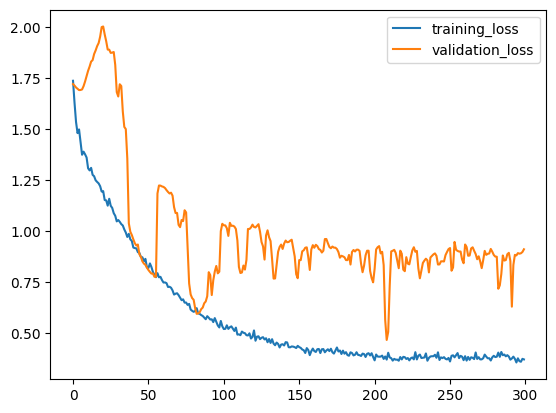

In [184]:
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label='validation_loss')
plt.legend()
plt.show()

## Dataset- X2 (HEART)

In [185]:
#partition

def Vmax(X):
  X= np.array(X)
  t = np.var(X,axis=0)
  mv = np.argmax(t)
  fp = np.argmax(np.abs(X[:,mv] - np.mean(X,axis=0)[mv]))
  vmax = X[:,mv][fp] - np.mean(X,axis=0)[mv]

  return vmax,mv

def P(X,indces):
  p = X[indces] - np.mean(X[indces],axis=0)
  d={}
  for i in range(len(indces)):d[indces[i]] = p[i]
  return d

def partitionDis2(X,C,tem,length,K_):
  k = len(C)
  if k <= math.ceil(length**(K_)):
    cmax= np.argmax(tem)
    vmax,mv = Vmax(X[C[cmax]])
    p = P(X,C[cmax])
    c1,c2,i1,i2=[],[],[],[]
    for i in C[cmax]:
      if (p[i][mv]*(vmax)) >= 0:c1.append(i)
      else:c2.append(i)
    C.pop(cmax),C.append(c1),C.append(c2)
    tem.pop(cmax),tem.append(sum(np.var(X[c1],axis=0))),tem.append(sum(np.var(X[c2],axis=0)))
    k= len(C)
    partitionDis2(X,C,tem,length,K_)

In [186]:
data = pd.read_csv('/content/drive/MyDrive/Dataset_for_me/heart_data.txt',sep=' ', header=None)
X2=np.array(data.iloc[:,:-1])

In [187]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [188]:
data.isnull().sum()

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [189]:
labels = np.array(data.iloc[:, -1])

k2 = len(set(labels))

In [190]:
C2 = [np.arange(len(X2))]
tem2 = [sum(np.var(X2[i],axis=0)) for i in C2]
partitionDis2(X2,C2,tem2,len(X2),1/2)

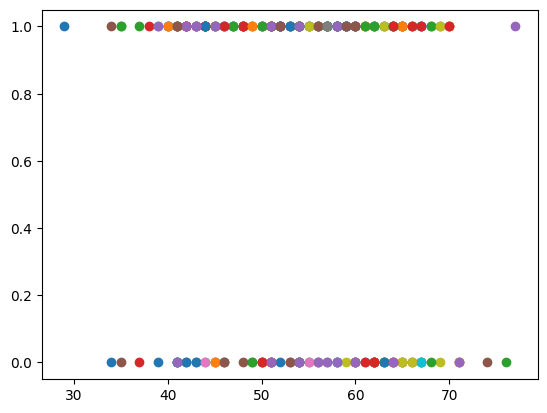

In [191]:
for i in C2:
  plt.scatter(X2[i][:,0], X2[i][:,1])

In [192]:
centroids2 = np.array([X2[cluster].mean(axis=0) for cluster in C2])

In [161]:
centroids2

array([[ 89.58436214,  68.18518519,  24.63786008,  21.53909465,
         20.01234568,   2.73868313],
       [ 89.33333333,  94.        ,  37.33333333,  33.        ,
        153.33333333,   2.16666667],
       [ 89.6       ,  70.4       ,  67.2       ,  36.        ,
        100.        ,   5.7       ],
       [ 92.        ,  60.        ,  30.        ,  27.        ,
        297.        ,   2.        ],
       [ 95.        ,  73.        ,  20.        ,  25.        ,
        225.        ,   8.        ],
       [ 98.        ,  66.        , 103.        ,  57.        ,
        114.        ,   6.        ],
       [ 91.25      ,  58.        ,  33.36111111,  27.08333333,
         55.33333333,   4.41666667],
       [ 91.83333333,  90.27777778,  28.77777778,  24.        ,
         50.44444444,   4.47222222],
       [ 90.28571429,  83.        ,  60.57142857,  42.71428571,
         55.14285714,   4.85714286],
       [ 96.        , 100.        ,  49.        ,  32.5       ,
         59.        ,  10.2

In [193]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial import distance

def k_round_MST_sgmst(X, K, adjMat_precomputed=False, SG=None):
    edges = []

    if not adjMat_precomputed:
        adjMat = np.tril(distance.cdist(X, X, 'euclidean'), -1)
    else:
        adjMat = csr_matrix((len(X), len(X)))
        adjMat[np.array(SG)[:, 0], np.array(SG)[:, 1]] = np.sqrt(np.sum((X[np.array(SG)[:, 0]] - X[np.array(SG)[:, 1]])**2, axis=1))

    for i in range(K):
        Tcsr = minimum_spanning_tree(csr_matrix(adjMat))
        a, b = np.where((Tcsr != 0).toarray())
        edges.append(np.column_stack((a, b)))

        if adjMat_precomputed:
            adjMat -= Tcsr
        else:
            adjMat -= Tcsr.toarray()

    return np.vstack(edges)

In [194]:
NG2 = k_round_MST_sgmst(centroids2,2)

In [195]:
import matplotlib.pyplot as plt

def draw_k_round_mst(X, edges, title='K-Round MST'):
    """
    X: data points (n_samples, n_features)
    edges: array of edge pairs (from k_round_MST_sgmst)
    title: plot title
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c='red', s=80, zorder=2, label='Points')

    # Draw MST edges
    for i, j in edges:
        x_vals = [X[i][0], X[j][0]]
        y_vals = [X[i][1], X[j][1]]
        plt.plot(x_vals, y_vals, 'k-', alpha=0.6, linewidth=2, zorder=1)

    plt.title(title)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()



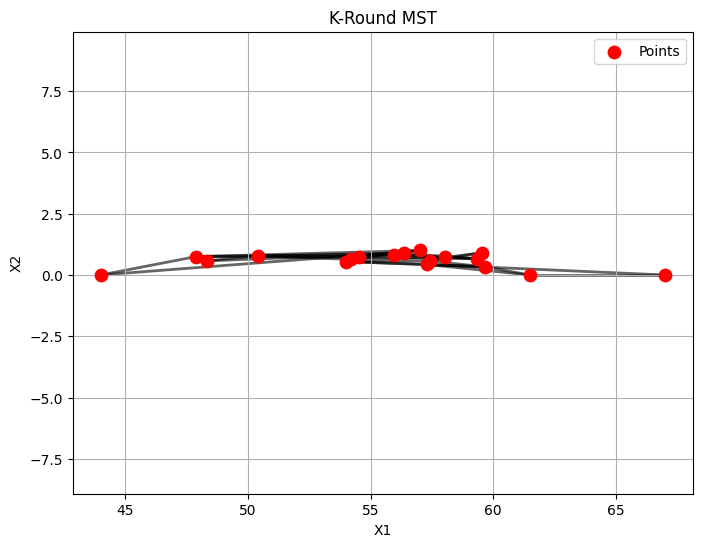

In [196]:
draw_k_round_mst(centroids2,k_round_MST_sgmst(centroids2,2))

In [197]:
def bipartite(p1,p2):
  return [[i,j] for i in p1 for j in p2]

In [198]:
G2 = []

for i,j in NG2:
  G2+= bipartite(C2[i],C2[j])


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


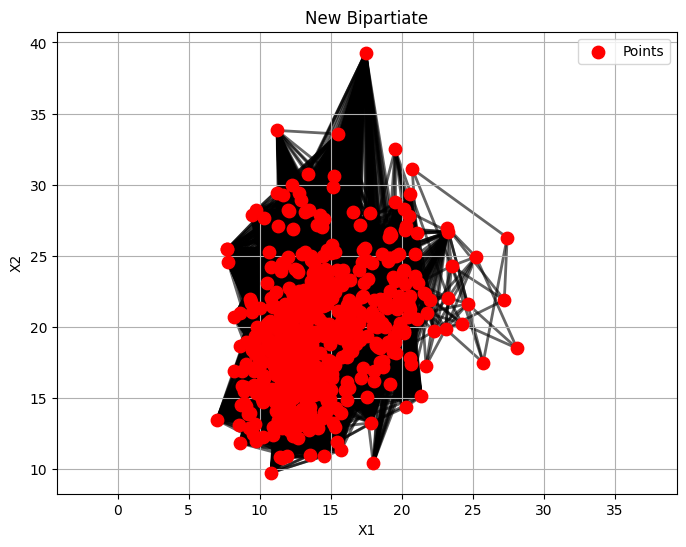

In [126]:
draw_k_round_mst(X2, G2, title='New Bipartiate')

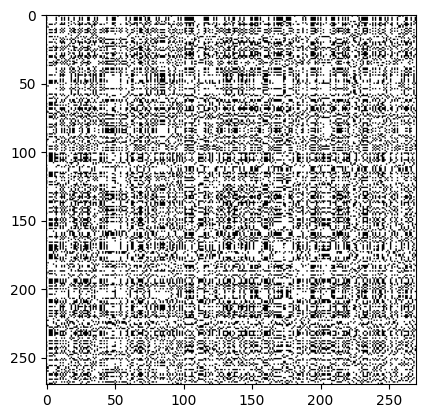

In [199]:
N2, f2 = X2.shape
G2 = np.array(G2)
A2 = lil_matrix((N2, N2))
A2[G2[:, 0], G2[:, 1]] = 1
A2[G2[:, 1], G2[:, 0]] = 1
plt.imshow(A2.toarray(), cmap='gray_r')

In [200]:
L2, D2 = laplacian(A2, return_diag=True)

In [207]:
val2, vec2 = eigsh(L2, k = 9)

In [208]:
vec2.shape

(270, 9)

In [209]:
def Spectral_embading(X,K):

  return vec

## Prediction on HEART Dataset

In [210]:
vec2.shape

(270, 9)

In [211]:
labels

array([2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1,
       2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2,
       1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1,
       2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 2, 2, 2,
       1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 1, 2,
       2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1,
       1, 2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
       2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1,
       1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1,
       2, 1, 1, 1, 1, 2])

In [212]:
le2 = LabelEncoder()
y_encoded2 = le.fit_transform(labels)

In [61]:
# from sklearn.model_selection import train_test_split

# X2_train, X2_test, y2_train, y2_test = train_test_split(vec2, labels, test_size=0.2, random_state=42)

In [213]:
# y_pred_prob = model.predict(X2_test)

y_pred_prob = model.predict(vec2)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [ ]:
 y_pred_prob

In [214]:
y_pred_labels = (y_pred_prob>0.5).astype(int).reshape(-1)

In [215]:
y_pred_labels

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0])

In [216]:
y_pred = le.inverse_transform(y_pred_labels)
y_test_original = le.inverse_transform(y_encoded2)

In [217]:
print("Classification Report:\n")
print(classification_report(y_test_original, y_pred))

Classification Report:

              precision    recall  f1-score   support

           1       0.57      0.73      0.64       150
           2       0.47      0.30      0.37       120

    accuracy                           0.54       270
   macro avg       0.52      0.52      0.50       270
weighted avg       0.53      0.54      0.52       270

